# LightGBM: Forecast

- load trained models
- compute ensemble
- export in submission format

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

In [4]:
use_covariates = False

# Load data

In [5]:
current_date = pd.Timestamp.now().date()
forecast_date = get_preceding_thursday(current_date)
forecast_date = str(forecast_date.date())
forecast_date

'2024-10-31'

In [6]:
ts_are = load_target_series('are', forecast_date)
ts_sari = load_target_series('sari', forecast_date)

covariates, target_series = retain_period_common_to_all([ts_sari, ts_are])

<Axes: xlabel='date'>

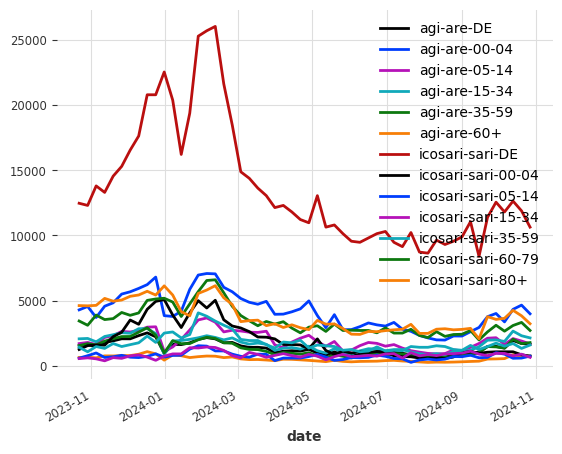

In [7]:
target_series.plot()
covariates.plot()

In [8]:
RANDOM_SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [13]:
path = f'models/{forecast_date}/'

In [16]:
dfs = []
for seed in RANDOM_SEEDS:
    model_path = path + f'{forecast_date}-lightgbm-{seed}.pt'
    print(model_path)
    model = LightGBMModel.load(model_path)
    df = compute_forecast(model, target_series, covariates if use_covariates else None, forecast_date, HORIZON, NUM_SAMPLES, vincentization=True, probabilistic_nowcast=True, local=True)
    dfs.append(df)

models/2024-10-31/2024-10-31-lightgbm-1.pt
models/2024-10-31/2024-10-31-lightgbm-2.pt
models/2024-10-31/2024-10-31-lightgbm-3.pt
models/2024-10-31/2024-10-31-lightgbm-4.pt
models/2024-10-31/2024-10-31-lightgbm-5.pt
models/2024-10-31/2024-10-31-lightgbm-6.pt
models/2024-10-31/2024-10-31-lightgbm-7.pt
models/2024-10-31/2024-10-31-lightgbm-8.pt
models/2024-10-31/2024-10-31-lightgbm-9.pt
models/2024-10-31/2024-10-31-lightgbm-10.pt


In [17]:
df = pd.concat(dfs)
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [18]:
df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])

In [19]:
df.to_csv(f'submissions/KIT-LightGBM/{forecast_date}-agi-are-KIT-LightGBM.csv', index=False)

# Plot forecasts

In [20]:
df = pd.read_csv(f'submissions/KIT-LightGBM/{forecast_date}-agi-are-KIT-LightGBM.csv', parse_dates=['target_end_date', 'forecast_date'])

In [21]:
source = target_series.components[0].split('-')[0]
indicator = target_series.components[0].split('-')[1]

In [22]:
df_plot = prepare_plot_data(df, target_series)

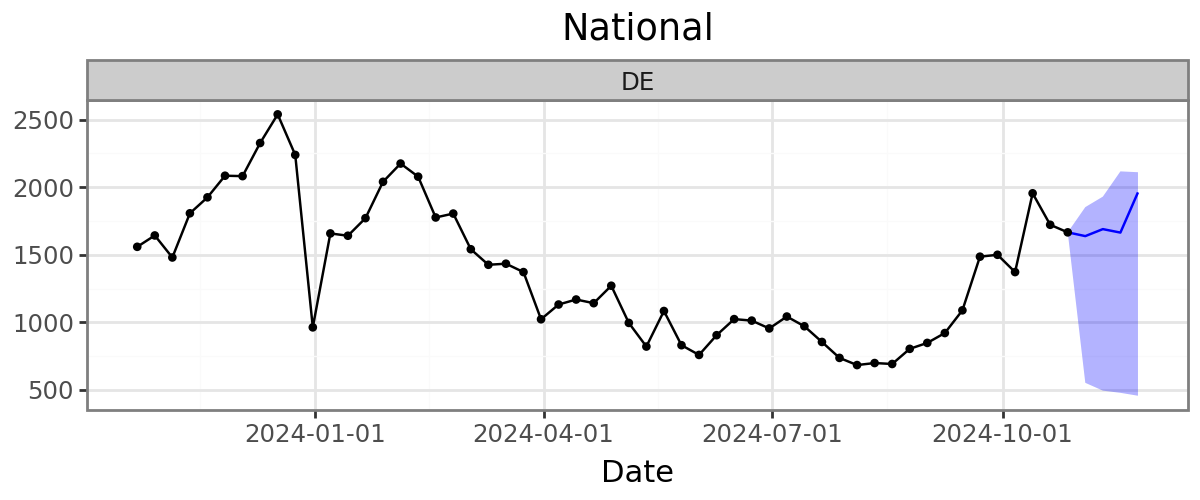

In [23]:
plot_forecasts(df_plot, 'national', start=0)

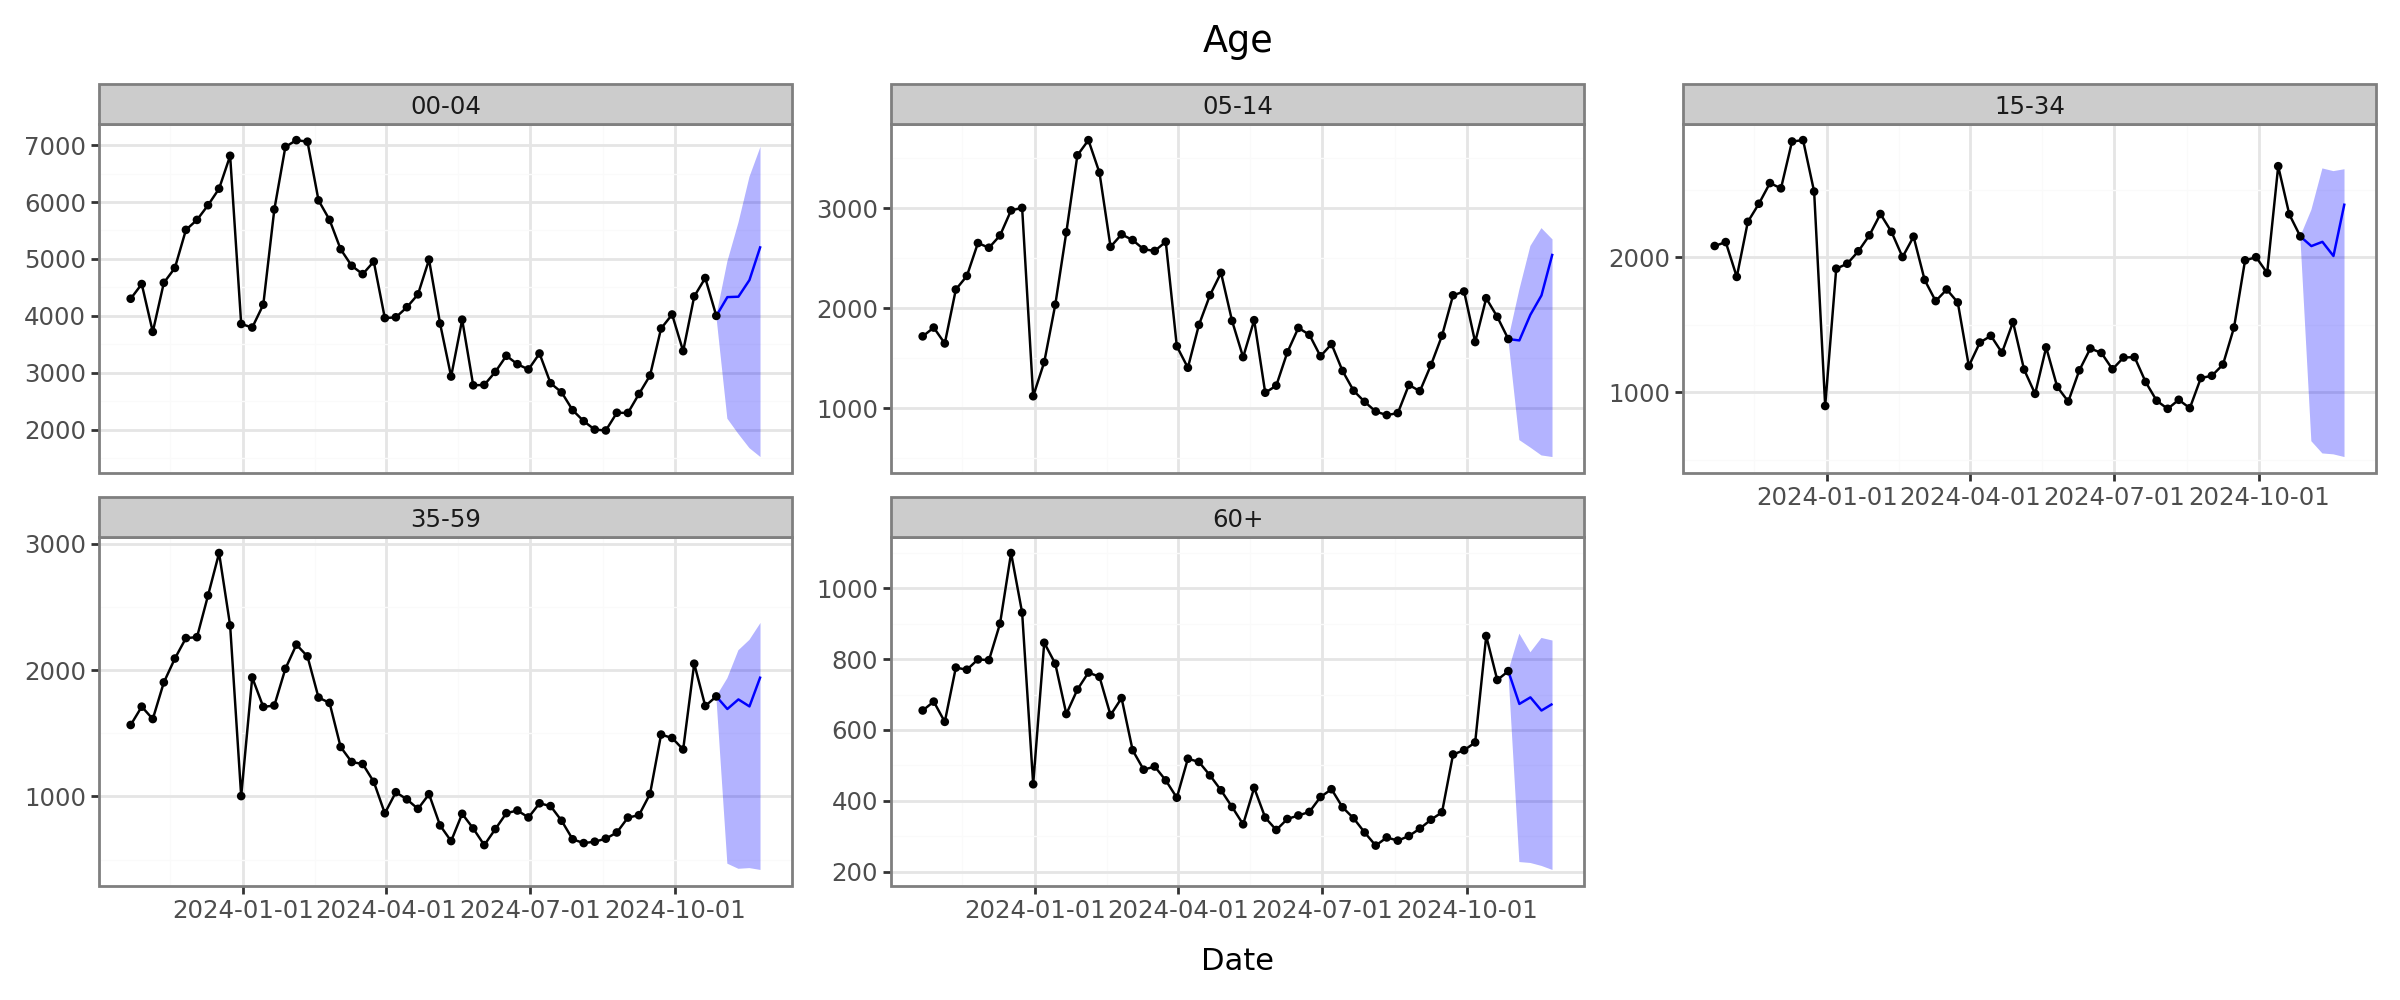

In [24]:
plot_forecasts(df_plot, 'age', start=0)

# Feature importance

In [25]:
source = model.lagged_label_names[0].split('-')[0]
indicator = model.lagged_label_names[0].split('-')[1]

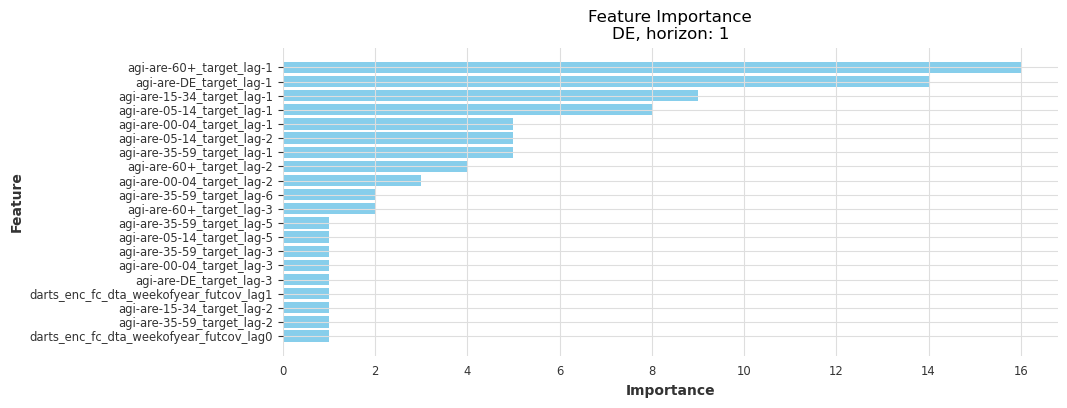

In [26]:
plot_importance_lgbm(model, horizon=1, max_features=20, y_size=4)

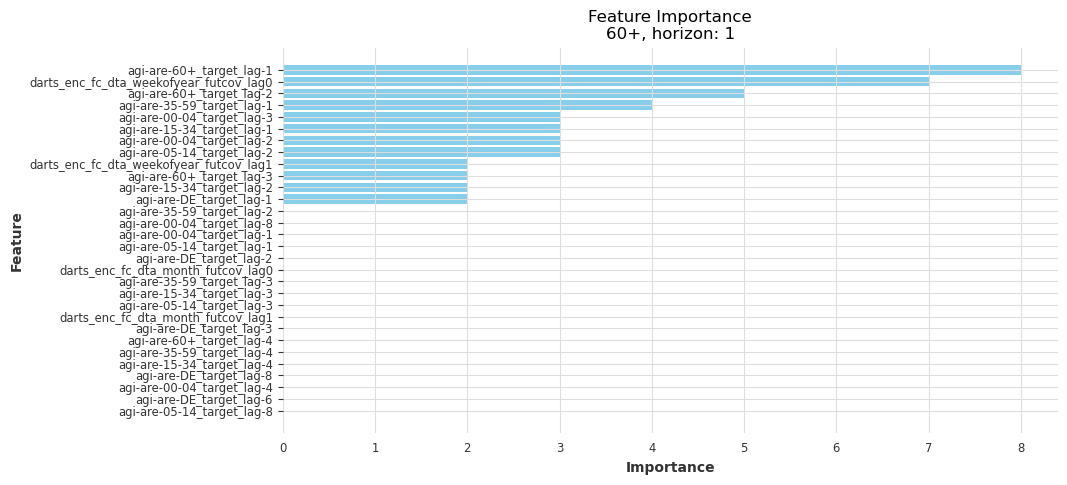

In [27]:
plot_importance_lgbm(model, age_group='60+', horizon=1, max_features=30, y_size=5)

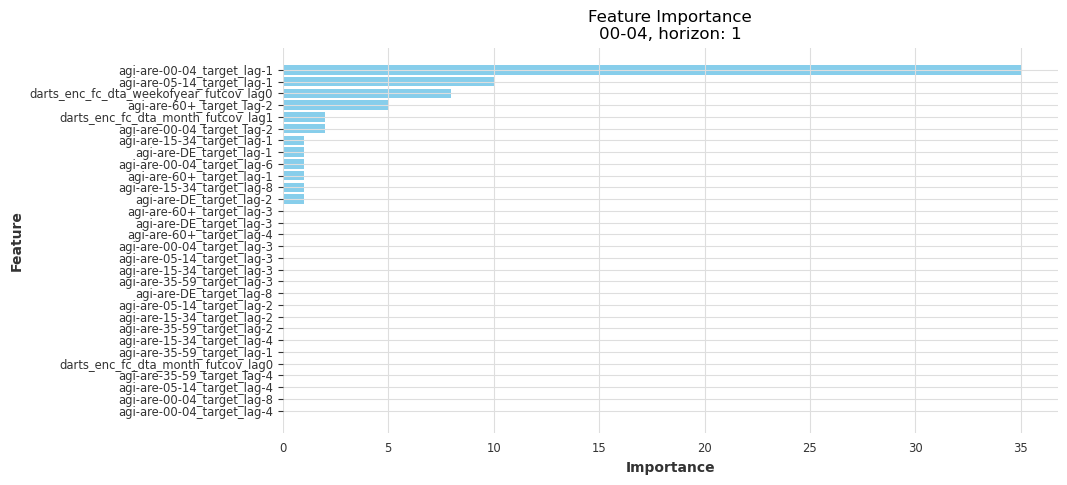

In [28]:
plot_importance_lgbm(model, age_group='00-04', horizon=1, max_features=30, y_size=5)